# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [143]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,roc_auc_score,accuracy_score

from tqdm import tqdm
import os

In [144]:
# using SQLite Table to read data.
con = sqlite3.connect('C:/Users/sesha/OneDrive/Desktop/ICONS/IMP/before/MINIPJ/Personal/AMAZON food review 2/database.sqlite')  

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [145]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [146]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [147]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [148]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [149]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that 

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [150]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [151]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [152]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

Observation:- It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [153]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [154]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [155]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [156]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [157]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [158]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [159]:

# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [160]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [161]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [162]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [163]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [164]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:25<00:00, 3406.68it/s]


In [165]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

In [166]:
final ['CleanedText']= preprocessed_reviews
final.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ...",infestation fruitflies literally everywhere fl...
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,0,1290038400,Doesn't work!! Don't waste your money!!,Worst product I have gotten in long time. Woul...,worst product gotten long time would rate no s...
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,0,1306972800,A big rip off,I wish I'd read the reviews before making this...,wish would read reviews making purchase basica...


In [167]:
preprocessed_summary = []
# tqdm is for printing the status bar
for summary in tqdm(final['Summary'].values): 
    summary = re.sub(r"http\S+", "", summary) 
    # remove urls from text python: https://stackoverflow.com/a/40823105/4084039 
    summary = BeautifulSoup(summary, 'lxml').get_text() 
    # https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element 
    summary = decontracted(summary)
    summary = re.sub("\S*\d\S*", "", summary).strip() #remove words with numbers python: https://stackoverflow.com/a/18082370/4084039 
    summary = re.sub('[^A-Za-z]+', ' ', summary) #remove spacial character: https://stackoverflow.com/a/5843547/4084039 
    # https://gist.github.com/sebleier/554280 
    summary = ' '.join(e.lower() for e in summary.split() if e.lower() not in stopwords) 
    preprocessed_summary.append(summary.strip()) 

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:18<00:00, 4793.59it/s]


In [168]:
preprocessed_reviews = [i + ' ' + j for i, j in zip(preprocessed_reviews,preprocessed_summary)] 
print(preprocessed_reviews[1500])

way hot blood took bite jig lol hot stuff


# FEATURIZATION

# BOW

In [169]:
X = np.array(final['CleanedText']) 
Y = np.array(final['Score']) 

In [170]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(final['preprocessed_reviews'], final['Score'], test_size=0.33, shuffle=False,random_state=0)
#X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33,shuffle=False,random_state=0)# this is for time series split
X_train, X_test, Y_train, Y_test = train_test_split(final['CleanedText'], final['Score'], test_size=0.33) # this is random splitting
X_train, X_cv, Y_train, Y_cv = train_test_split(X_train, Y_train, test_size=0.33) # this is random splitting


print(X_train.shape, Y_train.shape)
print(X_cv.shape, Y_cv.shape)
print(X_test.shape, Y_test.shape)

print("="*100)

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=10, max_features=500)
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, Y_train.shape)
print(X_cv_bow.shape, Y_cv.shape)
print(X_test_bow.shape, Y_test.shape)
print("="*100)

print("NOTE: THE NUMBER OF COLUMNS IN EACH OF THE VECTOR WONT BE SAME")


(39400,) (39400,)
(19407,) (19407,)
(28966,) (28966,)
After vectorizations
(39400, 500) (39400,)
(19407, 500) (19407,)
(28966, 500) (28966,)
NOTE: THE NUMBER OF COLUMNS IN EACH OF THE VECTOR WONT BE SAME


# BI-GRAMS AND N-GRAMS

In [171]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 500)
the number of unique words including both unigrams and bigrams  500


## TF-IDF

In [172]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

train_tf_idf = tf_idf_vect.transform(X_train)
cv_tf_idf = tf_idf_vect.transform(X_cv)
test_tf_idf = tf_idf_vect.transform(X_test)
print("the type of count vectorizer ",type(train_tf_idf))
print("the shape of out text TRAIN TFIDF vectorizer ",train_tf_idf.get_shape())
print("the shape of out text CV TFIDF vectorizer ",cv_tf_idf.get_shape())
print("the shape of out text TEST TFIDF vectorizer ",test_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams in train ", train_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['able', 'absolutely', 'actually', 'add', 'added', 'aftertaste', 'ago', 'almonds', 'almost', 'also']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TRAIN TFIDF vectorizer  (39400, 500)
the shape of out text CV TFIDF vectorizer  (19407, 500)
the shape of out text TEST TFIDF vectorizer  (28966, 500)
the number of unique words including both unigrams and bigrams in train  500


## [4.4] Word2Vec

In [173]:
# Train your own Word2Vec model using your own text corpus
i=0
sent_of_train=[]
for sentance in X_train:
    sent_of_train.append(sentance.split())

In [174]:
# Train your own Word2Vec model using your own text corpus
i=0
sent_of_test=[]
for sentance in X_test:
    sent_of_test.append(sentance.split())

In [175]:
# Train your own Word2Vec model using your own text corpus
i=0
sent_of_cv=[]
for sentance in X_cv:
    sent_of_cv.append(sentance.split())

In [176]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(sent_of_train,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have google's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.8232892751693726), ('wonderful', 0.8058362603187561), ('good', 0.8056924939155579), ('awesome', 0.7966526746749878), ('terrific', 0.7772451639175415), ('excellent', 0.7497335076332092), ('perfect', 0.7469338774681091), ('decent', 0.7462953329086304), ('amazing', 0.7259317636489868), ('nice', 0.7009961009025574)]
[('nastiest', 0.7710306644439697), ('best', 0.7522667646408081), ('greatest', 0.6840527057647705), ('experienced', 0.6813825964927673), ('smoothest', 0.6744863986968994), ('superior', 0.6606483459472656), ('compares', 0.6555820107460022), ('nicest', 0.6517893075942993), ('awful', 0.6271442174911499), ('tastiest', 0.6266165971755981)]


In [177]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  12093
sample words  ['young', 'grandmother', 'would', 'bring', 'back', 'cabin', 'always', 'thought', 'place', 'sold', 'well', 'amazon', 'com', 'year', 'violet', 'flavor', 'like', 'mouth', 'full', 'flowers', 'never', 'know', 'c', 'stood', 'users', 'zipfizz', 'since', 'first', 'came', 'not', 'good', 'kick', 'energy', 'working', 'travel', 'easy', 'put', 'carry', 'boost', 'road', 'love', 'chips', 'bursting', 'dip', 'easily', 'stand', 'alone', 'several', 'foodshouldtastegood', 'favorite']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [178]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv= []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(sent_of_cv): # for each review/sentence
    sent_vec_cv = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec_cv += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec_cv /= cnt_words
    sent_vectors_cv.append(sent_vec_cv)
sent_vectors_cv = np.array(sent_vectors_cv)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

100%|███████████████████████████████████████████████████████████████████████████| 19407/19407 [00:30<00:00, 639.95it/s]


19407
50


In [179]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train= []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(sent_of_train): # for each review/sentence
    sent_vec_train = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec_train += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec_train /= cnt_words
    sent_vectors_train.append(sent_vec_train)
sent_vectors_train = np.array(sent_vectors_train)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|███████████████████████████████████████████████████████████████████████████| 39400/39400 [00:57<00:00, 690.18it/s]


39400
50


In [180]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test= []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(sent_of_test): # for each review/sentence
    sent_vec_test = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec_test += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec_test /= cnt_words
    sent_vectors_test.append(sent_vec_test)
sent_vectors_test = np.array(sent_vectors_test)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 28966/28966 [00:35<00:00, 785.03it/s]


28966
50


#### [4.4.1.2] TFIDF weighted W2v

In [181]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary= dict(zip(model.get_feature_names(), list(model.idf_)))

In [182]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(sent_of_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 19407/19407 [04:35<00:00, 70.55it/s]


In [183]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(sent_of_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 28966/28966 [06:01<00:00, 80.06it/s]


In [184]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(sent_of_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 39400/39400 [08:07<00:00, 80.75it/s]


# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    2.7s finished


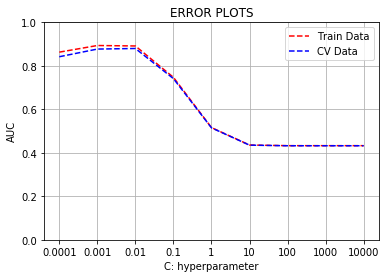

Optimal value of Alpha:  0.01  and Penalty is :  l2
--------------------------
Cv auc scores
[0.84518903 0.84189099 0.86114921 0.87719002 0.7353569  0.87982825
 0.51576153 0.74128729 0.5        0.51491967 0.5        0.43531546
 0.5        0.43250926 0.5        0.4325097  0.5        0.43250813]
Maximun Auc value : 0.8798282461973473


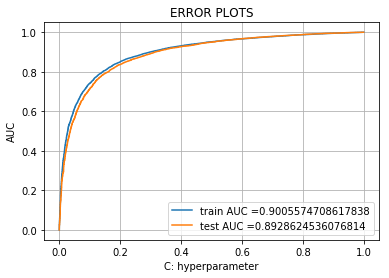

Train confusion matrix
[[ 5220  1131]
 [ 5449 27600]]
Test confusion matrix
[[ 3729   886]
 [ 4099 20252]]


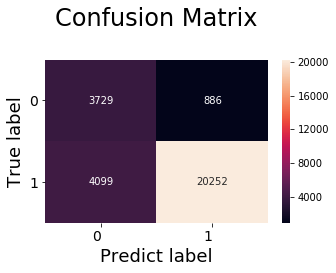

In [185]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, auc
from sklearn.model_selection import GridSearchCV

Alpha = [10**-4,10**-3,10**-2,10**-1,1,10,10**2,10**3,10**4]
Penal = ['l1','l2']
hyper_param = {'alpha':Alpha, 'penalty':Penal}
    
# We construct an estimator which is clf
clf = GridSearchCV(SGDClassifier(loss='hinge'),hyper_param,verbose=1,scoring='roc_auc')
clf.fit(X_train_bow,Y_train)
    
# Now for the base_estimator we gave our clf
calbr = CalibratedClassifierCV(clf, method = "sigmoid")
    
# Optimized values have to be obtained which are the best params in Alpha nd Penalty
alpha_opt, penalty_opt = clf.best_params_.get('alpha'), clf.best_params_.get('penalty') 
    
    
train_auc = clf.cv_results_.get('mean_train_score')
cv_auc_linear_bow = clf.cv_results_.get('mean_test_score')
x2 = np.arange(len(Alpha))
    

plt.plot(x2, train_auc[1::2],'r--', label = 'Train Data')
plt.plot(x2,cv_auc_linear_bow[1::2],'b--', label = 'CV Data')
plt.xticks(x2, Alpha)
plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
print("Optimal value of Alpha: ", alpha_opt , " and Penalty is : ", penalty_opt)
    
#Cv auc scores 
print("--------------------------")
print("Cv auc scores")
print(cv_auc_linear_bow)
print("Maximun Auc value :",max(cv_auc_linear_bow))
    
#test data
    
sgd = SGDClassifier(penalty=penalty_opt,alpha=alpha_opt,class_weight='balanced')
sgd.fit(X_train_bow,Y_train)
    
train_fpr, train_tpr, thresholds = roc_curve(Y_train, sgd.decision_function(X_train_bow))
test_fpr, test_tpr, thresholds = roc_curve(Y_test, sgd.decision_function(X_test_bow))                                             
                                                 
    
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
     
     
#Confusion Matrix
    
print("Train confusion matrix") 
print(confusion_matrix(Y_train, sgd.predict(X_train_bow))) 
print("Test confusion matrix")
print(confusion_matrix(Y_test, sgd.predict(X_test_bow)))
 
cm = confusion_matrix(Y_train, sgd.predict(X_train_bow))
cm = confusion_matrix(Y_test, sgd.predict(X_test_bow))
tn, fp, fn, tp = cm.ravel()
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
    
# Code for drawing seaborn heatmaps
class_names = ['0','1']
df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predict label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

In [186]:
SGD = SGDClassifier(penalty='l2',alpha=0.001)
SGD.fit(X_train_bow, Y_train)
feat_log = SGD.coef_

vectorizer = CountVectorizer(min_df=10, max_features=500)
p = vectorizer.fit_transform(X_train)
p = pd.DataFrame(feat_log.T,columns=['+ve'])
p['feature'] = vectorizer.get_feature_names()

#Sorting the values
q = p.sort_values(by = '+ve',kind = 'quicksort',ascending= False)

print("Top 10 features positive class", np.array(q['feature'][:10]))

Top 10 features positive class ['delicious' 'perfect' 'excellent' 'smooth' 'amazing' 'wonderful' 'nice'
 'great' 'best' 'highly']


In [187]:
print("Top 10 features negative class",np.array(q.tail(10)['feature']))


Top 10 features negative class ['thought' 'opened' 'maybe' 'item' 'guess' 'nothing' 'bad' 'away' 'money'
 'disappointed']


### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    2.2s finished


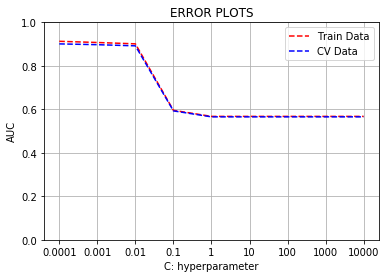

Optimal value of Alpha:  0.0001  and Penalty is :  l1
--------------------------
Cv auc scores
[0.90120808 0.90098101 0.7693024  0.89732398 0.5        0.89199611
 0.5        0.59290576 0.5        0.56542322 0.5        0.56542322
 0.5        0.56542322 0.5        0.56542322 0.5        0.56542322]
Maximun Auc value : 0.9012080835188742


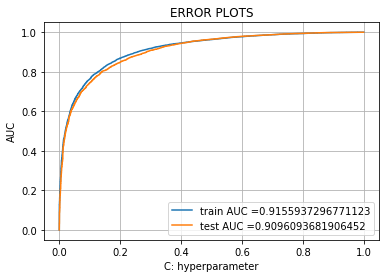

Train confusion matrix
[[ 5479   872]
 [ 6241 26808]]
Test confusion matrix
[[ 3925   690]
 [ 4709 19642]]


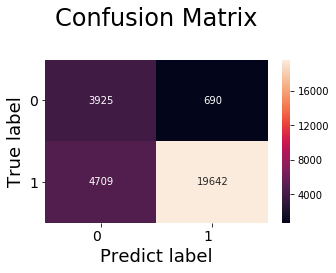

In [188]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, auc
from sklearn.model_selection import GridSearchCV

Alpha = [10**-4,10**-3,10**-2,10**-1,1,10,10**2,10**3,10**4]
Penal = ['l1','l2']
hyper_param = {'alpha':Alpha, 'penalty':Penal}
    
# We construct an estimator which is clf
clf = GridSearchCV(SGDClassifier(loss='hinge'),hyper_param,verbose=1,scoring='roc_auc')
clf.fit(train_tf_idf,Y_train)
    
# Now for the base_estimator we gave our clf
calbr = CalibratedClassifierCV(clf, method = "sigmoid")
    
# Optimized values have to be obtained which are the best params in Alpha nd Penalty
alpha_opt, penalty_opt = clf.best_params_.get('alpha'), clf.best_params_.get('penalty') 
    
    
train_auc = clf.cv_results_.get('mean_train_score')
cv_auc_linear_tfidf = clf.cv_results_.get('mean_test_score')
x2 = np.arange(len(Alpha))
    

plt.plot(x2, train_auc[1::2],'r--', label = 'Train Data')
plt.plot(x2,cv_auc_linear_tfidf[1::2],'b--', label = 'CV Data')
plt.xticks(x2, Alpha)
plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
print("Optimal value of Alpha: ", alpha_opt , " and Penalty is : ", penalty_opt)
    
#Cv auc scores 
print("--------------------------")
print("Cv auc scores")
print(cv_auc_linear_tfidf)
print("Maximun Auc value :",max(cv_auc_linear_tfidf))
    
#test data
    
sgd = SGDClassifier(penalty=penalty_opt,alpha=alpha_opt,class_weight='balanced')
sgd.fit(train_tf_idf,Y_train)
    
train_fpr, train_tpr, thresholds = roc_curve(Y_train, sgd.decision_function(train_tf_idf))
test_fpr, test_tpr, thresholds = roc_curve(Y_test, sgd.decision_function(test_tf_idf))                                             
                                                 
    
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
     
     
#Confusion Matrix
    
print("Train confusion matrix") 
print(confusion_matrix(Y_train, sgd.predict(train_tf_idf))) 
print("Test confusion matrix")
print(confusion_matrix(Y_test, sgd.predict(test_tf_idf)))
 
cm = confusion_matrix(Y_train, sgd.predict(train_tf_idf))
cm = confusion_matrix(Y_test, sgd.predict(test_tf_idf))
tn, fp, fn, tp = cm.ravel()
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
    
# Code for drawing seaborn heatmaps
class_names = ['0','1']
df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predict label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

In [189]:
SGD = SGDClassifier(penalty='l2',alpha=0.001)
SGD.fit(train_tf_idf, Y_train)
feat_log = SGD.coef_

vectorizer = CountVectorizer(min_df=10, max_features=500)
p = vectorizer.fit_transform(X_train)
p = pd.DataFrame(feat_log.T,columns=['+ve'])
p['feature'] = vectorizer.get_feature_names()

#Sorting the values
q = p.sort_values(by = '+ve',kind = 'quicksort',ascending= False)

print("Top 10 features positive class", np.array(q['feature'][:10]))

Top 10 features positive class ['gluten' 'bars' 'daughter' 'giving' 'list' 'live' 'people' 'etc' 'months'
 'without']


In [190]:
print("Top 10 features negative class",np.array(q.tail(10)['feature']))

Top 10 features negative class ['loved' 'online' 'natural' 'arrived' 'away' 'new' 'would' 'must' 'many'
 'definitely']


### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    3.4s finished


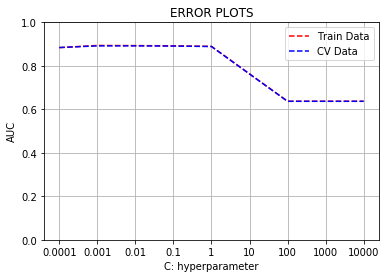

Optimal value of Alpha:  0.001  and Penalty is :  l2
--------------------------
Cv auc scores
[0.88158777 0.88410914 0.89063383 0.89197843 0.83743121 0.89196938
 0.5        0.89106283 0.5        0.88884418 0.5        0.76249959
 0.5        0.63697646 0.5        0.63697601 0.5        0.63697601]
Maximun Auc value : 0.8919784315628253


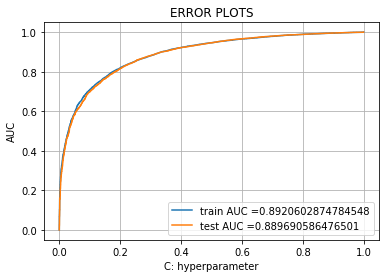

Train confusion matrix
[[ 5843   508]
 [10733 22316]]
Test confusion matrix
[[ 4204   411]
 [ 7809 16542]]


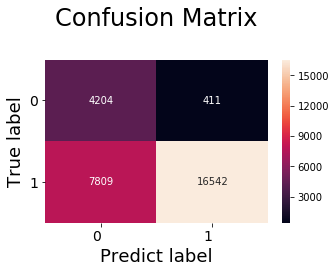

In [192]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, auc
from sklearn.model_selection import GridSearchCV

Alpha = [10**-4,10**-3,10**-2,10**-1,1,10,10**2,10**3,10**4]
Penal = ['l1','l2']
hyper_param = {'alpha':Alpha, 'penalty':Penal}
    
# We construct an estimator which is clf
clf = GridSearchCV(SGDClassifier(loss='hinge'),hyper_param,verbose=1,scoring='roc_auc')
clf.fit(sent_vectors_train,Y_train)
    
# Now for the base_estimator we gave our clf
calbr = CalibratedClassifierCV(clf, method = "sigmoid")
    
# Optimized values have to be obtained which are the best params in Alpha nd Penalty
alpha_opt, penalty_opt = clf.best_params_.get('alpha'), clf.best_params_.get('penalty') 
    
    
train_auc = clf.cv_results_.get('mean_train_score')
cv_auc_linear_avgw2v = clf.cv_results_.get('mean_test_score')
x2 = np.arange(len(Alpha))
    

plt.plot(x2, train_auc[1::2],'r--', label = 'Train Data')
plt.plot(x2,cv_auc_linear_avgw2v[1::2],'b--', label = 'CV Data')
plt.xticks(x2, Alpha)
plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
print("Optimal value of Alpha: ", alpha_opt , " and Penalty is : ", penalty_opt)
    
#Cv auc scores 
print("--------------------------")
print("Cv auc scores")
print(cv_auc_linear_avgw2v)
print("Maximun Auc value :",max(cv_auc_linear_avgw2v))
    
#test data
    
sgd = SGDClassifier(penalty=penalty_opt,alpha=alpha_opt,class_weight='balanced')
sgd.fit(sent_vectors_train,Y_train)
    
train_fpr, train_tpr, thresholds = roc_curve(Y_train, sgd.decision_function(sent_vectors_train))
test_fpr, test_tpr, thresholds = roc_curve(Y_test, sgd.decision_function(sent_vectors_test))                                             
                                                 
    
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
     
     
#Confusion Matrix
    
print("Train confusion matrix") 
print(confusion_matrix(Y_train, sgd.predict(sent_vectors_train))) 
print("Test confusion matrix")
print(confusion_matrix(Y_test, sgd.predict(sent_vectors_test)))
 
cm = confusion_matrix(Y_train, sgd.predict(sent_vectors_train))
cm = confusion_matrix(Y_test, sgd.predict(sent_vectors_test))
tn, fp, fn, tp = cm.ravel()
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
    
# Code for drawing seaborn heatmaps
class_names = ['0','1']
df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predict label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    5.5s finished


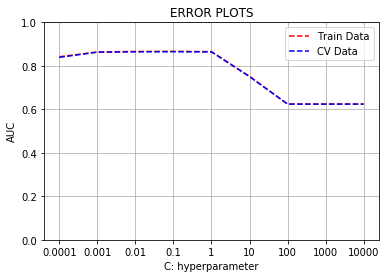

Optimal value of Alpha:  0.1  and Penalty is :  l2
--------------------------
Cv auc scores
[0.83965486 0.83916214 0.86474127 0.862839   0.78076971 0.864564
 0.5        0.86488433 0.5        0.86414198 0.5        0.75057354
 0.5        0.62404171 0.5        0.62404188 0.5        0.6240421 ]
Maximun Auc value : 0.8648843342246476


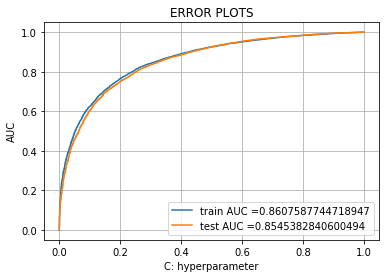

Train confusion matrix
[[ 5289  1062]
 [ 8956 24093]]
Test confusion matrix
[[ 3775   840]
 [ 6566 17785]]


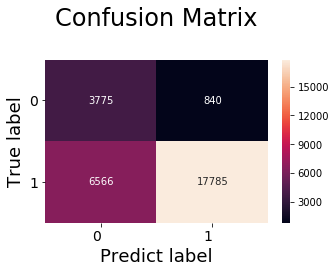

In [213]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, auc
from sklearn.model_selection import GridSearchCV

Alpha = [10**-4,10**-3,10**-2,10**-1,1,10,10**2,10**3,10**4]
Penal = ['l1','l2']
hyper_param = {'alpha':Alpha, 'penalty':Penal}
    
# We construct an estimator which is clf
clf = GridSearchCV(SGDClassifier(loss='hinge'),hyper_param,verbose=1,scoring='roc_auc')
clf.fit(tfidf_sent_vectors_train,Y_train)
    
# Now for the base_estimator we gave our clf
calbr = CalibratedClassifierCV(clf, method = "sigmoid")
    
# Optimized values have to be obtained which are the best params in Alpha nd Penalty
alpha_opt, penalty_opt = clf.best_params_.get('alpha'), clf.best_params_.get('penalty') 
    
    
train_auc = clf.cv_results_.get('mean_train_score')
cv_auc_linear_tfidfw2v = clf.cv_results_.get('mean_test_score')
x2 = np.arange(len(Alpha))
    

plt.plot(x2, train_auc[1::2],'r--', label = 'Train Data')
plt.plot(x2,cv_auc_linear_tfidfw2v[1::2],'b--', label = 'CV Data')
plt.xticks(x2, Alpha)
plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
print("Optimal value of Alpha: ", alpha_opt , " and Penalty is : ", penalty_opt)
    
#Cv auc scores 
print("--------------------------")
print("Cv auc scores")
print(cv_auc_linear_tfidfw2v)
print("Maximun Auc value :",max(cv_auc_linear_tfidfw2v))
    
#test data
    
sgd = SGDClassifier(penalty=penalty_opt,alpha=alpha_opt,class_weight='balanced')
sgd.fit(tfidf_sent_vectors_train,Y_train)
    
train_fpr, train_tpr, thresholds = roc_curve(Y_train, sgd.decision_function(tfidf_sent_vectors_train))
test_fpr, test_tpr, thresholds = roc_curve(Y_test, sgd.decision_function(tfidf_sent_vectors_test))                                             
                                                 
    
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
     
     
#Confusion Matrix
    
print("Train confusion matrix") 
print(confusion_matrix(Y_train, sgd.predict(tfidf_sent_vectors_train))) 
print("Test confusion matrix")
print(confusion_matrix(Y_test, sgd.predict(tfidf_sent_vectors_test)))
 
cm = confusion_matrix(Y_train, sgd.predict(tfidf_sent_vectors_train))
cm = confusion_matrix(Y_test, sgd.predict(tfidf_sent_vectors_test))
tn, fp, fn, tp = cm.ravel()
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
    
# Code for drawing seaborn heatmaps
class_names = ['0','1']
df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predict label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

## [5.2] RBF SVM

In [214]:
#First the data needs to be spliited using Time Based Splitting unlike the previous Random splitting
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
df_final = time_sorted_data.take(np.random.permutation(len(final))[:50000])
print(df_final.shape)
df_final.head()

(50000, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
43980,47869,B004SRH2B6,A1FFRNO3X7YARL,Karl G. Summers,6,9,0,1274400000,Worst coconut water EVER,"I've tried a lot of brands of coconut water, a...",tried lot brands coconut water found like zico...
25682,28040,B000ISB72E,A36L8XMWN7V79I,"slange ""Sharon""",0,0,1,1293840000,My dog loves them,I have a small 5.5 lb dog and she loves these ...,small lb dog loves pigs ears negative hard nee...
57653,62524,B004S7URGS,A2BMZYFWGSY7XK,LydiaLD,2,2,1,1315785600,Love this oatmeal!,I discovered this oatmeal quite by accident la...,discovered oatmeal quite accident last year lo...
68734,74750,B0026RQTGE,A3BUWBTRGMMJOB,C. Lavalle,0,0,1,1344816000,Great Chew Treat,Greenies are the special treat we give our gol...,greenies special treat give golden retriever g...
94914,103156,B001E5E2RC,A1RGH5ON7D59FS,P. Buchan,1,15,0,1254096000,Avoid DAB nutrition!,"If you buy this product from DAB nutrition, yo...",buy product dab nutrition pay almost much ship...


In [215]:
# Assigning the Values to X and y
x = df_final['CleanedText'].values
y = df_final['Score'].values

In [216]:
# Assigning x_train, x_test and x_cv
x_train=time_sorted_data["CleanedText"][0:13000]
x_cv=time_sorted_data["CleanedText"][13000:16000]
x_test=time_sorted_data["CleanedText"][16000:20000]


In [217]:
# Assigning y_train, y_test and y_cv
y_train=time_sorted_data['Score'][0:13000]
y_cv=time_sorted_data['Score'][13000:16000]
y_test=time_sorted_data['Score'][16000:20000]

print(X_train.shape, "   ", y_train.shape)
print(X_cv.shape, "   ", y_cv.shape)
print(X_test.shape, "   ", y_test.shape)

(39400,)     (13000,)
(19407,)     (3000,)
(28966,)     (4000,)


## RBF BOW

In [218]:
vectorizer = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
vectorizer.fit_transform(x_train)
x_train_bow = vectorizer.transform(x_train)
x_cv_bow  = vectorizer.transform(x_cv)
x_test_bow = vectorizer.transform(x_test)

In [219]:
print(X_train_bow.shape)
print(X_cv_bow.shape)
print(X_test_bow.shape)

(39400, 500)
(19407, 500)
(28966, 500)


## RBF TFIDF 

In [220]:
#Splitting into train, test and cv
vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
tf_idf_vect = vect.fit(x_train)
x_train_tfidf = tf_idf_vect.transform(x_train) 
x_cv_tfidf = tf_idf_vect.transform(x_cv)
x_test_tfidf = tf_idf_vect.transform(x_test)

print(x_train_tfidf.shape)
print(x_cv_tfidf.shape) 
print(x_test_tfidf.shape)


(13000, 500)
(3000, 500)
(4000, 500)


## RBF Word2Vec

In [221]:
i=0
sent_of_train_rbf=[]
for sentance in x_train:
    sent_of_train_rbf.append(sentance.split())

In [222]:
i=0
sent_of_test_rbf=[]
for sentance in x_test:
    sent_of_test_rbf.append(sentance.split())

In [223]:
i=0
sent_of_cv_rbf=[]
for sentance in x_cv:
    sent_of_cv_rbf.append(sentance.split())

In [224]:
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model_rbf=Word2Vec(sent_of_train_rbf,min_count=5,size=50, workers=4)
    print(w2v_model_rbf.wv.most_similar('great'))
    print('='*50)
    print(w2v_model_rbf.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have google's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('good', 0.8448069095611572), ('excellent', 0.7817649841308594), ('wonderful', 0.7583207488059998), ('fantastic', 0.7183851003646851), ('quick', 0.708759069442749), ('delicious', 0.7082414031028748), ('tasty', 0.6973310708999634), ('well', 0.6789325475692749), ('awesome', 0.6748924851417542), ('perfect', 0.673982560634613)]
[('compares', 0.9775400757789612), ('explain', 0.97630774974823), ('commented', 0.975833535194397), ('greatest', 0.9751748442649841), ('bear', 0.9743539094924927), ('tastiest', 0.9738014936447144), ('bunch', 0.9728738069534302), ('lollipops', 0.9728473424911499), ('corporate', 0.9724793434143066), ('popular', 0.9711036682128906)]


In [225]:
w2v_words_rbf = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_rbf))
print("sample words ", w2v_words_rbf[0:50])

number of words that occured minimum 5 times  12093
sample words  ['young', 'grandmother', 'would', 'bring', 'back', 'cabin', 'always', 'thought', 'place', 'sold', 'well', 'amazon', 'com', 'year', 'violet', 'flavor', 'like', 'mouth', 'full', 'flowers', 'never', 'know', 'c', 'stood', 'users', 'zipfizz', 'since', 'first', 'came', 'not', 'good', 'kick', 'energy', 'working', 'travel', 'easy', 'put', 'carry', 'boost', 'road', 'love', 'chips', 'bursting', 'dip', 'easily', 'stand', 'alone', 'several', 'foodshouldtastegood', 'favorite']


## RBF AVG W2V

In [226]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train_rbf= []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(sent_of_train_rbf): # for each review/sentence
    sent_vec_train_rbf = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec_train_rbf += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec_train_rbf /= cnt_words
    sent_vectors_train_rbf.append(sent_vec_train_rbf)
sent_vectors_train_rbf = np.array(sent_vectors_train_rbf)
print(len(sent_vectors_train_rbf))
print(len(sent_vectors_train_rbf[0]))

100%|███████████████████████████████████████████████████████████████████████████| 13000/13000 [00:29<00:00, 436.86it/s]


13000
50


In [227]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test_rbf= []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(sent_of_test_rbf): # for each review/sentence
    sent_vec_test_rbf = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec_test_rbf += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec_test_rbf /= cnt_words
    sent_vectors_test_rbf.append(sent_vec_test_rbf)
sent_vectors_test_rbf = np.array(sent_vectors_test_rbf)
print(len(sent_vectors_test_rbf))
print(len(sent_vectors_test_rbf[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:09<00:00, 443.01it/s]


4000
50


In [228]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv_rbf= []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(sent_of_cv_rbf): # for each review/sentence
    sent_vec_cv_rbf = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec_cv_rbf += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec_cv_rbf /= cnt_words
    sent_vectors_cv_rbf.append(sent_vec_cv_rbf)
sent_vectors_cv_rbf = np.array(sent_vectors_cv_rbf)
print(len(sent_vectors_cv_rbf))
print(len(sent_vectors_cv_rbf[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 436.58it/s]


3000
50


## RBF TFIDF W2V

In [229]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model_rbf = TfidfVectorizer()
tf_idf_matrix_rbf = model_rbf.fit_transform(x_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary_rbf= dict(zip(model_rbf.get_feature_names(), list(model_rbf.idf_)))

In [230]:
# TF-IDF weighted Word2Vec
tfidf_feat_rbf = model_rbf.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train_rbf = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(sent_of_train_rbf): # for each review/sentence 
    sent_vec_rbf = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat_rbf:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary_rbf[word]*(sent.count(word)/len(sent))
            sent_vec_rbf += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec_rbf /= weight_sum
    tfidf_sent_vectors_train_rbf.append(sent_vec_rbf)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 13000/13000 [03:38<00:00, 59.37it/s]


In [231]:
# TF-IDF weighted Word2Vec
tfidf_feat_rbf = model_rbf.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test_rbf = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(sent_of_test_rbf): # for each review/sentence 
    sent_vec_rbf = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat_rbf:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary_rbf[word]*(sent.count(word)/len(sent))
            sent_vec_rbf += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec_rbf /= weight_sum
    tfidf_sent_vectors_test_rbf.append(sent_vec_rbf)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [01:06<00:00, 59.78it/s]


In [232]:
# TF-IDF weighted Word2Vec
tfidf_feat_rbf = model_rbf.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv_rbf = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(sent_of_cv_rbf): # for each review/sentence 
    sent_vec_rbf = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat_rbf:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary_rbf[word]*(sent.count(word)/len(sent))
            sent_vec_rbf += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec_rbf /= weight_sum
    tfidf_sent_vectors_cv_rbf.append(sent_vec_rbf)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:52<00:00, 57.17it/s]


### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

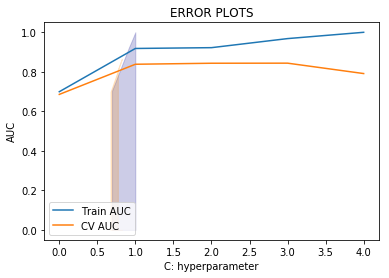

Optimal value of C:  100
--------------------------
Cv auc scores
[0.68521145 0.83764515 0.84279658 0.84318298 0.79062869]
Maximun Auc value : 0.8431829829620058


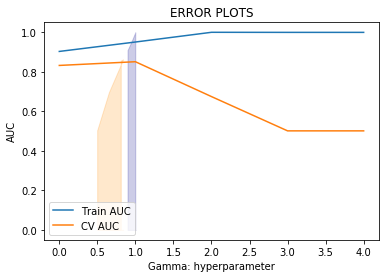

Optimal value of gamma:  0.01


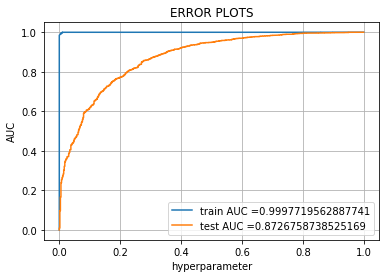

Train confusion matrix
[[ 1510     9]
 [   77 11404]]
Test confusion matrix
[[ 298  254]
 [ 205 3243]]


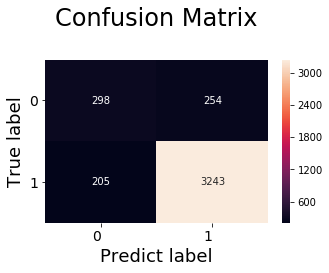

In [236]:
from sklearn.svm import SVC 
C = [10**-4, 10**-2, 10**0, 10**2, 10**4]
hyper_param  = [{'C':C}]
    
     
clf = GridSearchCV(SVC(kernel = "rbf", probability=True), hyper_param, cv = 3, scoring = "roc_auc")
clf.fit(x_train_bow,y_train)
alpha_opt = clf.best_params_.get("C") 


train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc_rbf_bow = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(cv_auc_rbf_bow, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(cv_auc_rbf_bow - cv_auc_std,cv_auc_rbf_bow + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
    
print("Optimal value of C: ", alpha_opt)
    
#Cv auc scores 
print("--------------------------")
print("Cv auc scores")
print(cv_auc_rbf_bow)
print("Maximun Auc value :",max(cv_auc_rbf_bow))
 
    
gamma = [10**-4, 10**-2, 10**0, 10**2, 10**4]
tunned_param  = [{'gamma':gamma}]
clf = GridSearchCV(SVC(kernel = "rbf", probability=True), tunned_param, cv = 3, scoring = "roc_auc")
clf.fit(x_train_bow,y_train)
gamma_opt = clf.best_params_.get("gamma")

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc_rbf_bow = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
    
    
plt.plot(train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(cv_auc_rbf_bow, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(cv_auc_rbf_bow - cv_auc_std,cv_auc_rbf_bow + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("Gamma: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
     
print("Optimal value of gamma: ", gamma_opt)

      
model = SVC(C=alpha_opt, gamma = gamma_opt, kernel = "rbf",class_weight='balanced', probability=True)
model.fit(x_train_bow,y_train)

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(x_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.legend()
plt.xlabel("hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()                                           
                                                     
#Confusion Matrix    
print("Train confusion matrix") 
print(confusion_matrix(y_train, model.predict(x_train_bow))) 
print("Test confusion matrix")
print(confusion_matrix(y_test, model.predict(x_test_bow)))
 
cm = confusion_matrix(y_train, model.predict(x_train_bow))
cm = confusion_matrix(y_test, model.predict(x_test_bow))
tn, fp, fn, tp = cm.ravel()
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
# Code for drawing seaborn heatmaps
class_names = ['0','1']
df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predict label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

In [237]:
SGD = SGDClassifier(penalty='l2',alpha=0.001)
SGD.fit(x_train_bow, y_train)
feat_log = SGD.coef_

vectorizer = CountVectorizer(min_df=10, max_features=500)
p = vectorizer.fit_transform(x_train)
p = pd.DataFrame(feat_log.T,columns=['+ve'])
p['feature'] = vectorizer.get_feature_names()

#Sorting the values
q = p.sort_values(by = '+ve',kind = 'quicksort',ascending= False)

print("Top 10 features positive class", np.array(q['feature'][:10]))

Top 10 features positive class ['pleased' 'everyone' 'snacks' 'deal' 'loves' 'got' 'aftertaste' 'thing'
 'hard' 'family']


In [238]:
print("Top 10 features negative class",np.array(q.tail(10)['feature']))

Top 10 features negative class ['thanks' 'away' 'overall' 'red' 'might' 'time' 'maybe' 'artificial'
 'money' 'diet']


### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

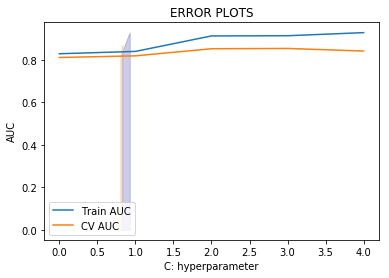

Optimal value of C:  100
--------------------------
Cv auc scores
[0.81126801 0.81896168 0.85235516 0.85375106 0.84150967]
Maximun Auc value : 0.8537510620264631


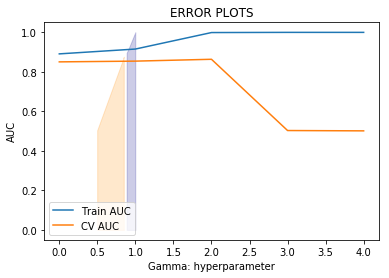

Optimal value of gamma:  1


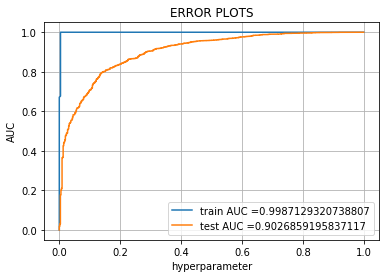

Train confusion matrix
[[ 1513     6]
 [    0 11481]]
Test confusion matrix
[[ 204  348]
 [  66 3382]]


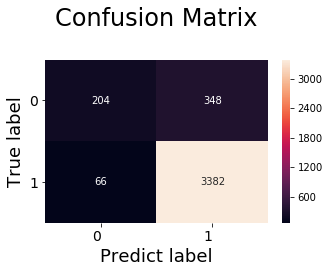

In [239]:
from sklearn.svm import SVC 
C = [10**-4, 10**-2, 10**0, 10**2, 10**4]
hyper_param  = [{'C':C}]
    
     
clf = GridSearchCV(SVC(kernel = "rbf", probability=True), hyper_param, cv = 3, scoring = "roc_auc")
clf.fit(x_train_tfidf,y_train)
alpha_opt = clf.best_params_.get("C") 


train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc_rbf_tfidf = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(cv_auc_rbf_tfidf, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(cv_auc_rbf_tfidf - cv_auc_std,cv_auc_rbf_tfidf + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
    
print("Optimal value of C: ", alpha_opt)
    
#Cv auc scores 
print("--------------------------")
print("Cv auc scores")
print(cv_auc_rbf_tfidf)
print("Maximun Auc value :",max(cv_auc_rbf_tfidf))
 
    
gamma = [10**-4, 10**-2, 10**0, 10**2, 10**4]
tunned_param  = [{'gamma':gamma}]
clf = GridSearchCV(SVC(kernel = "rbf", probability=True), tunned_param, cv = 3, scoring = "roc_auc")
clf.fit(x_train_tfidf,y_train)
gamma_opt = clf.best_params_.get("gamma")

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc_rbf_tfidf = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
    
    
plt.plot(train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(cv_auc_rbf_tfidf, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(cv_auc_rbf_tfidf - cv_auc_std,cv_auc_rbf_tfidf + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("Gamma: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
     
print("Optimal value of gamma: ", gamma_opt)

      
model = SVC(C=alpha_opt, gamma = gamma_opt, kernel = "rbf",class_weight='balanced', probability=True)
model.fit(x_train_tfidf,y_train)

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(x_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.legend()
plt.xlabel("hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()                                           
                                                     
#Confusion Matrix    
print("Train confusion matrix") 
print(confusion_matrix(y_train, model.predict(x_train_tfidf))) 
print("Test confusion matrix")
print(confusion_matrix(y_test, model.predict(x_test_tfidf)))
 
cm = confusion_matrix(y_train, model.predict(x_train_tfidf))
cm = confusion_matrix(y_test, model.predict(x_test_tfidf))
tn, fp, fn, tp = cm.ravel()
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
# Code for drawing seaborn heatmaps
class_names = ['0','1']
df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predict label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

In [240]:
SGD = SGDClassifier(penalty='l2',alpha=0.001)
SGD.fit(x_train_tfidf, y_train)
feat_log = SGD.coef_

vectorizer = CountVectorizer(min_df=10, max_features=500)
p = vectorizer.fit_transform(x_train)
p = pd.DataFrame(feat_log.T,columns=['+ve'])
p['feature'] = vectorizer.get_feature_names()

#Sorting the values
q = p.sort_values(by = '+ve',kind = 'quicksort',ascending= False)

print("Top 10 features positive class", np.array(q['feature'][:10]))

Top 10 features positive class ['got' 'deal' 'going' 'loves' 'everyone' 'pleased' 'beans' 'nice' 'work'
 'snacks']


In [241]:
print("Top 10 features negative class",np.array(q.tail(10)['feature']))

Top 10 features negative class ['flavors' 'time' 'note' 'artificial' 'diet' 'wrong' 'maybe' 'away' 'non'
 'money']


### [5.2.2] Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

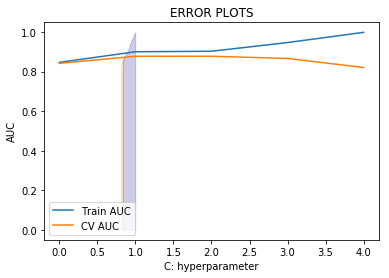

Optimal value of C:  1
--------------------------
Cv auc scores
[0.84170105 0.87747035 0.87768586 0.86646763 0.82085622]
Maximun Auc value : 0.8776858646790019


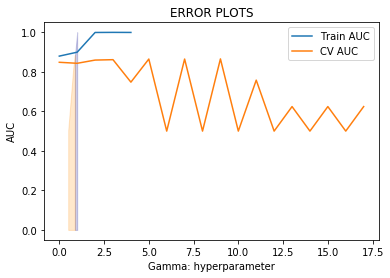

Optimal value of gamma:  0.01


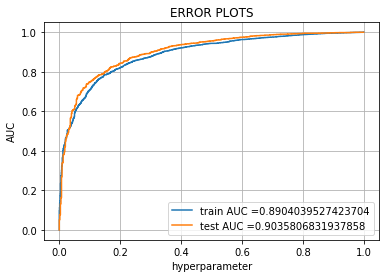

Train confusion matrix
[[1313  206]
 [2644 8837]]
Test confusion matrix
[[ 475   77]
 [ 731 2717]]


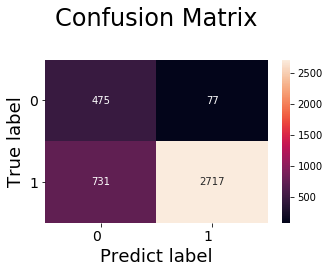

In [243]:
from sklearn.svm import SVC 
C = [10**-4, 10**-2, 10**0, 10**2, 10**4]
hyper_param  = [{'C':C}]
    
     
clf = GridSearchCV(SVC(kernel = "rbf", probability=True), hyper_param, cv = 3, scoring = "roc_auc")
clf.fit(sent_vectors_train_rbf,y_train)
alpha_opt = clf.best_params_.get("C") 


train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc_rbf_avgw2v = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(cv_auc_rbf_avgw2v, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(cv_auc_rbf_avgw2v - cv_auc_std,cv_auc_rbf_avgw2v + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
    
print("Optimal value of C: ", alpha_opt)
    
#Cv auc scores 
print("--------------------------")
print("Cv auc scores")
print(cv_auc_rbf_avgw2v)
print("Maximun Auc value :",max(cv_auc_rbf_avgw2v))
 
    
gamma = [10**-4, 10**-2, 10**0, 10**2, 10**4]
tunned_param  = [{'gamma':gamma}]
clf = GridSearchCV(SVC(kernel = "rbf", probability=True), tunned_param, cv = 3, scoring = "roc_auc")
clf.fit(sent_vectors_train_rbf,y_train)
gamma_opt = clf.best_params_.get("gamma")

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc_rbf_avgw2v = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
    
    
plt.plot(train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(cv_auc_rbf_avgw2v - cv_auc_std,cv_auc_rbf_avgw2v + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("Gamma: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
     
print("Optimal value of gamma: ", gamma_opt)

      
model = SVC(C=alpha_opt, gamma = gamma_opt, kernel = "rbf",class_weight='balanced', probability=True)
model.fit(sent_vectors_train_rbf,y_train)

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(sent_vectors_train_rbf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(sent_vectors_test_rbf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.legend()
plt.xlabel("hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()                                           
                                                     
#Confusion Matrix    
print("Train confusion matrix") 
print(confusion_matrix(y_train, model.predict(sent_vectors_train_rbf))) 
print("Test confusion matrix")
print(confusion_matrix(y_test, model.predict(sent_vectors_test_rbf)))
 
cm = confusion_matrix(y_train, model.predict(sent_vectors_train_rbf))
cm = confusion_matrix(y_test, model.predict(sent_vectors_test_rbf))
tn, fp, fn, tp = cm.ravel()
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
# Code for drawing seaborn heatmaps
class_names = ['0','1']
df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predict label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

### [5.2.2] Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

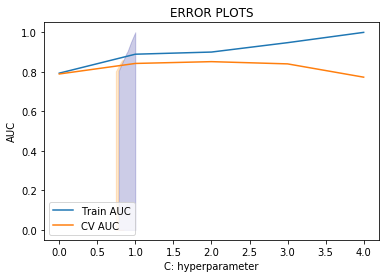

Optimal value of C:  1
--------------------------
Cv auc scores
[0.78865003 0.84192294 0.85099723 0.83971555 0.7724697 ]
Maximun Auc value : 0.8509972316378536


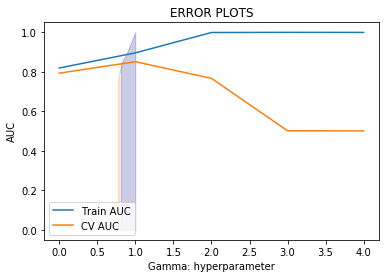

Optimal value of gamma:  0.01


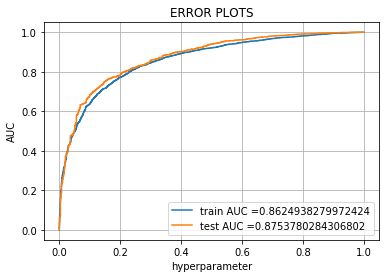

Train confusion matrix
[[1284  235]
 [3208 8273]]
Test confusion matrix
[[ 471   81]
 [ 876 2572]]


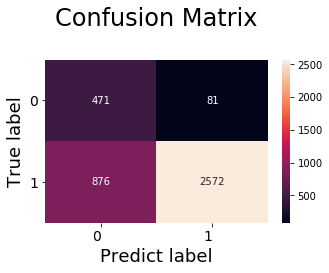

In [245]:
from sklearn.svm import SVC 
C = [10**-4, 10**-2, 10**0, 10**2, 10**4]
hyper_param  = [{'C':C}]
    
     
clf = GridSearchCV(SVC(kernel = "rbf", probability=True), hyper_param, cv = 3, scoring = "roc_auc")
clf.fit( tfidf_sent_vectors_train_rbf,y_train)
alpha_opt = clf.best_params_.get("C") 


train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc_rbf_tfidfw2v = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(cv_auc_rbf_tfidfw2v, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(cv_auc_rbf_tfidfw2v - cv_auc_std,cv_auc_rbf_tfidfw2v + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
    
print("Optimal value of C: ", alpha_opt)
    
#Cv auc scores 
print("--------------------------")
print("Cv auc scores")
print(cv_auc_rbf_tfidfw2v)
print("Maximun Auc value :",max(cv_auc_rbf_tfidfw2v))
 
    
gamma = [10**-4, 10**-2, 10**0, 10**2, 10**4]
tunned_param  = [{'gamma':gamma}]
clf = GridSearchCV(SVC(kernel = "rbf", probability=True), tunned_param, cv = 3, scoring = "roc_auc")
clf.fit( tfidf_sent_vectors_train_rbf,y_train)
gamma_opt = clf.best_params_.get("gamma")

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
    
    
plt.plot(train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(cv_auc_rbf_tfidfw2v - cv_auc_std,cv_auc_rbf_tfidfw2v + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("Gamma: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
     
print("Optimal value of gamma: ", gamma_opt)

      
model = SVC(C=alpha_opt, gamma = gamma_opt, kernel = "rbf",class_weight='balanced', probability=True)
model.fit(sent_vectors_train_rbf,y_train)

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba( tfidf_sent_vectors_train_rbf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba( tfidf_sent_vectors_test_rbf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.legend()
plt.xlabel("hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()                                           
                                                     
#Confusion Matrix    
print("Train confusion matrix") 
print(confusion_matrix(y_train, model.predict( tfidf_sent_vectors_train_rbf))) 
print("Test confusion matrix")
print(confusion_matrix(y_test, model.predict( tfidf_sent_vectors_test_rbf)))
 
cm = confusion_matrix(y_train, model.predict( tfidf_sent_vectors_train_rbf))
cm = confusion_matrix(y_test, model.predict( tfidf_sent_vectors_test_rbf))
tn, fp, fn, tp = cm.ravel()
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
# Code for drawing seaborn heatmaps
class_names = ['0','1']
df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predict label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

## [6] Conclusions

In [252]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["S.NO","MODEL","TYPE OF SVM","HYPER PARAMATER","AUC"]

x.add_row(["1","BAG OF WORDS","Linear","0.001",max(cv_auc_linear_bow)])
x.add_row(["2","TFIDF","Linear","0.001",max(cv_auc_linear_tfidf)])
x.add_row(["3","AVGW2V","Linear","0.001",max(cv_auc_linear_avgw2v)])
x.add_row(["4","TFIDFW2V","Linear","0.001",max(cv_auc_linear_tfidfw2v)])
x.add_row(["5","BAG OF WORDS","RBF","1",max(cv_auc_rbf_bow)])
x.add_row(["6","TFIDF","RBF","1",max(cv_auc_rbf_tfidf)])
x.add_row(["7","AVGW2V","RBF","1",max(cv_auc_rbf_avgw2v)])
x.add_row(["8","TFIDFW2V","RBF","1",max(cv_auc_rbf_tfidfw2v)])

# Printing the Table
print(x)

+------+--------------+-------------+-----------------+--------------------+
| S.NO |    MODEL     | TYPE OF SVM | HYPER PARAMATER |        AUC         |
+------+--------------+-------------+-----------------+--------------------+
|  1   | BAG OF WORDS |    Linear   |      0.001      | 0.8798282461973473 |
|  2   |    TFIDF     |    Linear   |      0.001      | 0.9012080835188742 |
|  3   |    AVGW2V    |    Linear   |      0.001      | 0.8919784315628253 |
|  4   |   TFIDFW2V   |    Linear   |      0.001      | 0.8648843342246476 |
|  5   | BAG OF WORDS |     RBF     |        1        | 0.8506474198586554 |
|  6   |    TFIDF     |     RBF     |        1        | 0.8629786612906645 |
|  7   |    AVGW2V    |     RBF     |        1        | 0.877484315547044  |
|  8   |   TFIDFW2V   |     RBF     |        1        | 0.8509972316378536 |
+------+--------------+-------------+-----------------+--------------------+


1. Linear kernel is much faster than the RBF kernel.
2. Linear TFIDF has given maximum AUC value compared to all the other models.